In [1]:
import fbprophet

In [2]:

#For the initial data exploration
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta

In [3]:
#For data visualisation
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import matplotlib.font_manager
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from matplotlib.pylab import rcParams


In [4]:
#For the time series modelling
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

#Suppress warnings from showing
import warnings
warnings.filterwarnings('ignore')

#Allow ourselves to save models
import pickle

In [5]:
#Define colours for the visuals
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
CB91_Crimson = '#CD3333'
CB91_Black = '#000000'
CB91_Oliver = '#9ACD32'
CB91_Orange = '#FF8247'


CB91_BlueD = '#016794'
CB91_GreenD = '#187970'
CB91_PinkD = '#B317B1'
CB91_PurpleD = '#4E1762'
CB91_VioletD = '#330E4C'
CB91_AmberD = '#985E09'

CB91_BlueL = '#ABE5FF'
CB91_GreenL = '#B5F1EB'
CB91_PinkL = '#FAD9FA'
CB91_PurpleL = '#D9A8EB'
CB91_VioletL = '#ECD4F5'
CB91_AmberL = '#F9D094'

In [6]:
#The following gradients will be used for heatmaps, etc
CB91_Grad_BP = ['#2CBDFE', '#2fb9fc', '#33b4fa', '#36b0f8',
                '#3aacf6', '#3da8f4', '#41a3f2', '#449ff0',
                '#489bee', '#4b97ec', '#4f92ea', '#528ee8',
                '#568ae6', '#5986e4', '#5c81e2', '#607de0',
                '#6379de', '#6775dc', '#6a70da', '#6e6cd8',
                '#7168d7', '#7564d5', '#785fd3', '#7c5bd1',
                '#7f57cf', '#8353cd', '#864ecb', '#894ac9',
                '#8d46c7', '#9042c5', '#943dc3', '#9739c1',
                '#9b35bf', '#9e31bd', '#a22cbb', '#a528b9',
                '#a924b7', '#ac20b5', '#b01bb3', '#b317b1']

In [7]:
#A list that we'll use to cycle through colors in charts
color_list = [CB91_Blue, CB91_Green, CB91_Amber, CB91_Pink,
              CB91_Violet, CB91_BlueD, CB91_GreenD, CB91_Purple,
                CB91_AmberD, CB91_PinkD, CB91_VioletD]

In [8]:
#Use seaborn to set all the default chart visual settings
sns.set(font='Franklin Gothic Book',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'white',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":16})

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

# 2) Data Pre-Processing

In [9]:
df = pd.read_csv('Data/zillow_data.csv')
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


In [10]:
df['Metro'].fillna('Not known', inplace = True)
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


Text(0.5, 1.0, 'Number of Regions that Do not have price Data at given date')

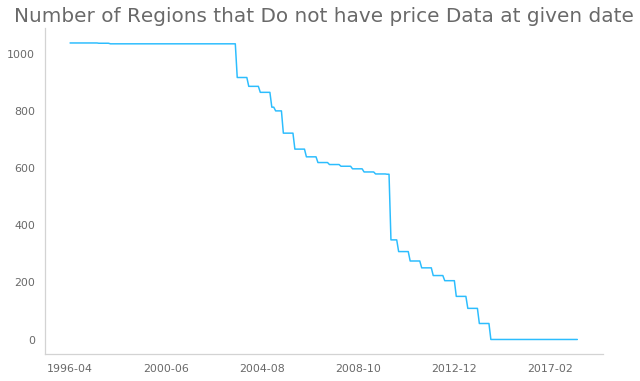

In [11]:
plt.figure(figsize=(10,6))
df.iloc[:,7:].isna().sum().plot();#####. Columns after No.7'
plt.title('Number of Regions that Do not have price Data at given date')

In [12]:
df.columns[139:]

Index(['2007-04', '2007-05', '2007-06', '2007-07', '2007-08', '2007-09',
       '2007-10', '2007-11', '2007-12', '2008-01',
       ...
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04'],
      dtype='object', length=133)

In [13]:
df.dropna(inplace=True, subset = list(df.columns[139:]))
#df.columns[139:] represents the months of April'07 onwards...a

In [14]:
list(df.columns[:7])

['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']

In [15]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')
df.columns = list(df.columns[:7]) + list(get_datetimes(df))

In [16]:
df_states = gpd.read_file("./States/states.shp")
#Change map projection
df_states = df_states.to_crs(epsg = 3395)
#Get the states in alphabetical order and set index
df_states = df_states.sort_values('STATE_ABBR')
df_states.set_index('STATE_ABBR', inplace = True)

# 3)  EDA and Visualization

In [17]:
def gradient_mapper(kpi,grad):
    
    kpi_min = kpi.min()
    kpi_max = kpi.max()
    colors = len(grad)-1
    first_map = list(map(lambda x: int(round(colors*(x-kpi_min) / (kpi_max-kpi_min),0)),list(kpi)))
    return list(map(lambda x: grad[x], first_map))


In [18]:
def state_map(kpi, grad, states = list(df_states.index),annot=True,pacific = True, dc = True,size = 30,cb = True):
    df_temp = df_states.loc[states,['geometry',kpi]]
    
    df_temp = df_temp.dropna()
    
    pacific_states = ['AK','HI']
    mainland_states = list(filter(lambda x: x not in pacific_states, list(df_temp.index)))
        
    if dc == False and dc in states:
        df_temp = df_temp.drop('DC')
        mainland_states.remove('DC')
        
    if pacific == False and 'HI' in states and 'AK' in states:
        df_temp = df_temp.drop(['HI','AK'])
        
        #... and the color gradient that we assign with the gradient mapper
    df_temp['Colors'] = gradient_mapper(kpi=df_temp[kpi],grad=grad)
        #declare a figure and axes
    fig, ax = plt.subplots(figsize=(size,size/2))
        #consider the mainland states first, plotting them in turn
    for i in mainland_states:
        df_temp.loc[[i]].plot(ax=ax, color=df_temp.loc[i,'Colors'])
                
        #if we are annotating...
        if annot == True:
            
            #locate the centre of each state...
            centroid = df_temp.loc[[i]].centroid
            
            #and plot the text there
            plt.annotate(s=f'{round(df_temp.loc[i,kpi],1)}',
                 xy=(centroid.x[i], centroid.y[i]),
                 horizontalalignment='center',
                 color='white',
                 fontsize=size/2)
            
    #Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    #plot the Pacific states in separate subplots
    if pacific == True:
        if 'AK' in states:
            ax2 = fig.add_subplot(3,6,13)
            df_states.loc[['AK']].plot(ax=ax2,
                                       color=df_temp.loc['AK','Colors'])
            ax2.patch.set_alpha(0)
            ax2.set_xticks([])
            ax2.set_yticks([])
        
        if 'HI' in states:
            ax3 = fig.add_subplot(3,6,14)
            df_states.loc[['HI']].plot(ax=ax3,
                                       color=df_temp.loc['HI','Colors'])
            ax3.patch.set_alpha(0)
            ax3.set_xticks([])
            ax3.set_yticks([])
        
    #plot the colorbar
    if cb == True:        
        cmap = LinearSegmentedColormap.from_list(name= '', colors=grad, N=50)
        ax4 = fig.add_subplot(1,30,30)
        norm = mpl.colors.Normalize(vmin=df_temp[kpi].min(),
                                    vmax=df_temp[kpi].max())
        cb = mpl.colorbar.ColorbarBase(ax4, cmap=cmap,
                                       norm=norm, orientation='vertical')
        
        
    sns.despine(left=True,bottom=True)        ######   Removing axes spines

In [19]:
df_states['RegionCount'] = df.groupby('State').count()['RegionID'] 
#### We have to point RegionID here, because sometimes other columns' data maybe missing
#df_states['RegionCount'] 

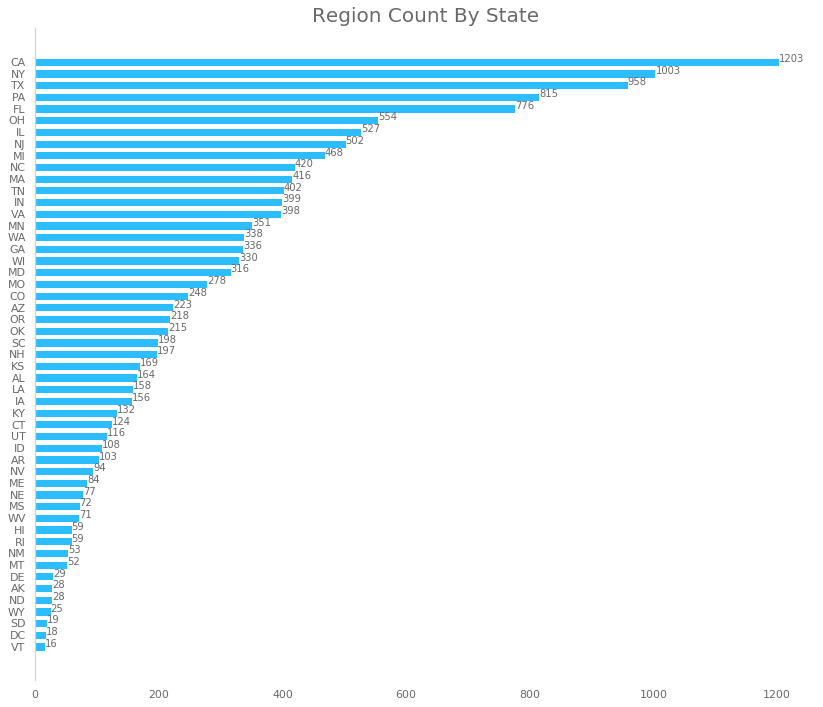

In [20]:
plt.figure(figsize=(14,12))

df_states_ordered = df_states.sort_values("RegionCount")
plt.barh(df_states_ordered.index,df_states_ordered['RegionCount'],height=0.7)
#matplotlib.pyplot.barh(y, width, height=0.8, left=None, *, align='center', **kwargs)
#y : scalar or array-like; width: scalar or array-like, width(s) of the bars.
#The y coordinates of the bars. See also align for the alignment of the bars to the coordinates.
#### https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.barh.html ###

sns.despine(bottom=True)  #### Without bottom line
#plt.xticks([])
#plt.ylim(0,51)
plt.title('Region Count By State')

for i, v in enumerate(df_states_ordered['RegionCount']):
    plt.text(v,i,str((v)), fontsize=10)

In [21]:
#The same data as a map...
#state_map(kpi = 'RegionCount', grad = CB91_Grad_BP, annot=False, pacific=True)

In [22]:
#Number of regions present in each state
#df_states['RegionCount'] = df.groupby('State').count()['RegionID']

#The median and mean region value by state
df_states['18-04_median'] = df.groupby(
    'State').median()[pd.to_datetime('2018-04', format='%Y-%m')]

df_states['18-04_mean'] = df.groupby(
    'State').mean()[pd.to_datetime('2018-04', format='%Y-%m')]

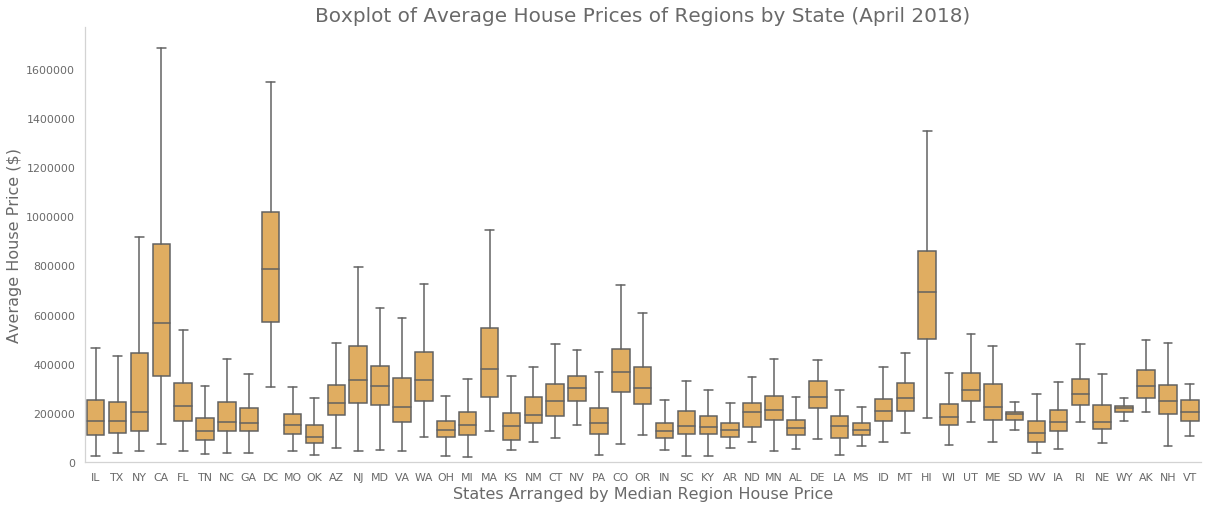

In [23]:
plt.figure(figsize=(20,8))

y = pd.to_datetime('2018-04-01', format='%Y-%m')

#state_order = df_states['18-04_median'].sort_values(ascending=False).index

sns.boxplot(x='State',y=y,
            data=df,
            showfliers=False, color = CB91_Amber)

plt.ylim(0,);
plt.xlabel('States Arranged by Median Region House Price')
plt.ylabel('Average House Price ($)')
plt.title('Boxplot of Average House Prices of Regions by State (April 2018)');

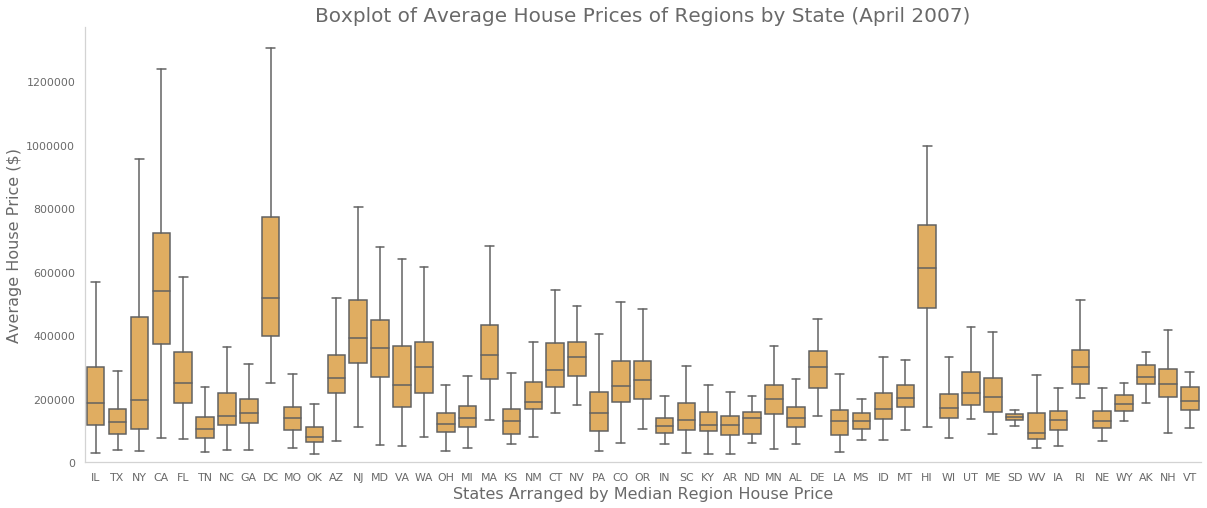

In [24]:
plt.figure(figsize=(20,8))

y = pd.to_datetime('2007-04-01', format='%Y-%m')

#state_order = df_states['18-04_median'].sort_values(ascending=False).index

sns.boxplot(x='State',y=y,
            data=df,
            showfliers=False, color = CB91_Amber)

plt.ylim(0,);
plt.xlabel('States Arranged by Median Region House Price')
plt.ylabel('Average House Price ($)')
plt.title('Boxplot of Average House Prices of Regions by State (April 2007)');

In [25]:
#state_map(kpi = '18-04_median', grad = CB91_Grad_AP, annot=False, pacific = True, dc = False)

In [26]:
#state_map(kpi='18-04_median',states = df_states.sort_values('18-04_median').index[:4],grad = CB91_Grad_AP, annot=False, pacific = True, dc = False)

In [27]:
#Create an empty dataframe...
df_sum = pd.DataFrame()

#And populate with summary statistics, quantities percentage
df_sum['Mean'] = df.mean()
df_sum['Min'] = df.min()
df_sum['05%'] = df.quantile(0.05)
df_sum['25%'] = df.quantile(0.25)
df_sum['50%'] = df.quantile(0.5)
df_sum['75%'] = df.quantile(0.75)
df_sum['95%'] = df.quantile(0.95)
df_sum['Max'] = df.max()
#### Well, we remove the non-digital columns automatically, but...
#Drop non-date rows, and reset the index
df_sum.drop(['RegionID','RegionName','SizeRank'], inplace=True)
df_sum.reset_index(inplace=True)

In [28]:
df_sum.tail()

,index,Mean,Min,05%,25%,50%,75%,95%,Max
260,2017-12-01,287190.682833,14300,76000.0,133500.0,198600.0,320700.0,758000.0,18307100
261,2018-01-01,288804.481316,14100,76210.0,134100.0,199500.0,322600.0,762090.0,18365900
262,2018-02-01,290560.306318,13900,76700.0,134700.0,200600.0,324350.0,766410.0,18530400
263,2018-03-01,292744.160817,13800,77310.0,135500.0,202400.0,326300.0,771680.0,18337700
264,2018-04-01,294301.481954,13800,77900.0,136200.0,203600.0,328000.0,776740.0,17894900


In [29]:
plt.figure(figsize=(12,12))

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

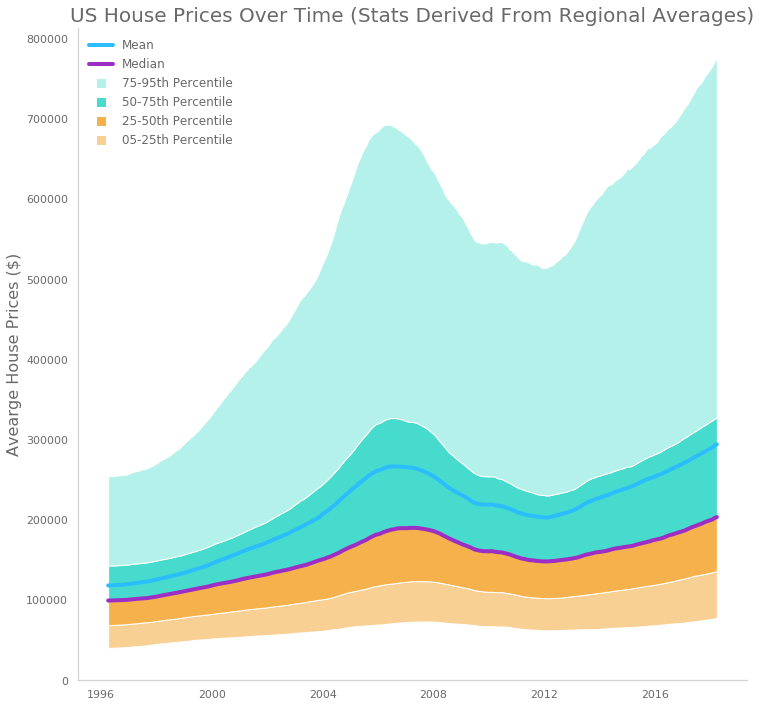

In [30]:
plt.figure(figsize=(12,12))

x = df_sum['index'].dt.to_pydatetime()

plt.plot(x,df_sum['Mean'],lw = 4, label = 'Mean House Price')
plt.plot(x, df_sum['50%'],lw = 4, label = 'Mean House Price', color = CB91_Purple)

plt.fill_between(x, df_sum['05%'], df_sum['25%'], facecolor=CB91_AmberL, interpolate=True)
plt.fill_between(x, df_sum['25%'], df_sum['50%'], facecolor=CB91_Amber, interpolate=True)
plt.fill_between(x, df_sum['50%'], df_sum['75%'], facecolor=CB91_Green, interpolate=True)
plt.fill_between(x, df_sum['75%'], df_sum['95%'], facecolor=CB91_GreenL, interpolate=True)

#plt.xticks([df_sum['index'][i] for i in range(len(df_sum)) if i%24 == 0])


#plt.xlim(df_sum['index'][0],df_sum['index'][len(df_sum)-1]);
plt.ylim(0,);

plt.title('US House Prices Over Time (Stats Derived From Regional Averages)')
plt.ylabel('Avearge House Prices ($)')

#################.  To assume Legend.   ####################
custom_lines = [Line2D([0], [0], c=CB91_Blue, lw=4,
                       markerfacecolor=CB91_GreenL, markersize=10),
                Line2D([0], [0], c=CB91_Purple, lw=4,
                       markerfacecolor=CB91_GreenL, markersize=10),
                Line2D([0], [0], marker='s', c='w',
                       markerfacecolor=CB91_GreenL, markersize=10),
                Line2D([0], [0], marker='s', c='w',
                       markerfacecolor=CB91_Green, markersize=10),
                Line2D([0], [0], marker='s', c='w',
                       markerfacecolor=CB91_Amber, markersize=10),
                Line2D([0], [0], marker='s', c='w',
                       markerfacecolor=CB91_AmberL, markersize=10),]
    
plt.legend(custom_lines,
           ['Mean','Median',
            '75-95th Percentile', '50-75th Percentile',
            '25-50th Percentile', '05-25th Percentile'],
           loc = 2,
           fontsize = 12,
           frameon=False);



In [31]:
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,Not known,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


In [32]:
#We create a new dataframe df_stats which will hold this information
################################################################
#############. Calculate increasing percentage #################
df_stats = df[list(df.columns[:7])]

#Get the prices as at the start...
Apr96 = pd.to_datetime('1996-04', format='%Y-%m')
df_stats['Apr96'] = df[Apr96]

#Get the prices as at the peak...
Apr07 = pd.to_datetime('2007-04', format='%Y-%m')
df_stats['Apr07'] = df[Apr07]

#... the trough...
Apr12 = pd.to_datetime('2012-04', format='%Y-%m')
df_stats['Apr12'] = df[Apr12]

#... and the end point
Apr18 = pd.to_datetime('2018-04', format='%Y-%m')
df_stats['Apr18'] = df[Apr18]
###### ******************************************  ###########
#Then calculate the growth rate between each of these points for each region
df_stats['96-07%'] = df_stats['Apr07'] / df_stats['Apr96'] - 1
df_stats['07-12%'] = df_stats['Apr12'] / df_stats['Apr07'] - 1
df_stats['12-18%'] = df_stats['Apr18'] / df_stats['Apr12'] - 1

df_stats.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Apr96,Apr07,Apr12,Apr18,96-07%,07-12%,12-18%
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,912000.0,740300.0,1030600,1.728905,-0.188268,0.392138
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,211000.0,201800.0,321800,-0.104794,-0.043602,0.594648
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,245100.0,252400.0,329900,0.164924,0.029784,0.307052
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,1184800.0,938100.0,1307000,1.378639,-0.208221,0.393242
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,126000.0,112800.0,121500,0.630013,-0.104762,0.077128


In [33]:

df_states['96-07%_mean'] = df_stats.groupby('State').mean()['96-07%']
df_states['07-12%_mean'] = df_stats.groupby('State').mean()['07-12%']
df_states['12-18%_mean'] = df_stats.groupby('State').mean()['12-18%']


In [34]:
#state_map('96-07%_mean',grad=CB91_Grad_BP,annot=False)

In [35]:
#state_map('07-12%_mean',grad=CB91_Grad_BP,annot=False)

In [36]:
#state_map('12-18%_mean',grad=CB91_Grad_BP,annot=False)

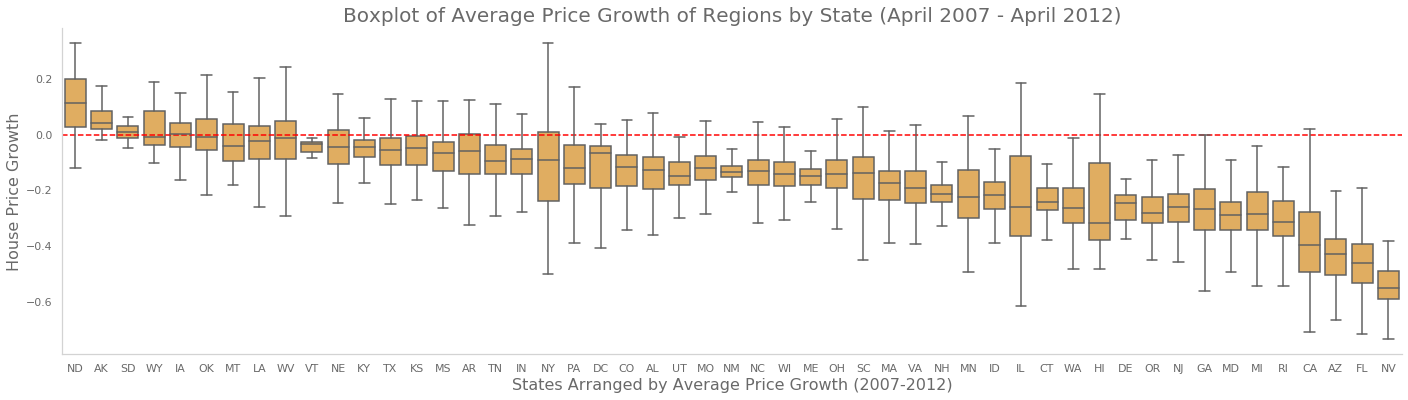

In [37]:
plt.figure(figsize=(24,6))

state_order = df_states['07-12%_mean'].sort_values(ascending=False).index

plt.axhline(0,color='red',ls="--")

sns.boxplot(x='State',y='07-12%',
            data=df_stats,order=state_order,
            showfliers=False, color = CB91_Amber)

#plt.ylim();
plt.xlabel('States Arranged by Average Price Growth (2007-2012)')
plt.ylabel('House Price Growth')
plt.title('Boxplot of Average Price Growth of Regions by State (April 2007 - April 2012)');

Text(0.5, 1.0, 'Boxplot of Average Price Growth of Regions by State (April 2012 - April 2018)')

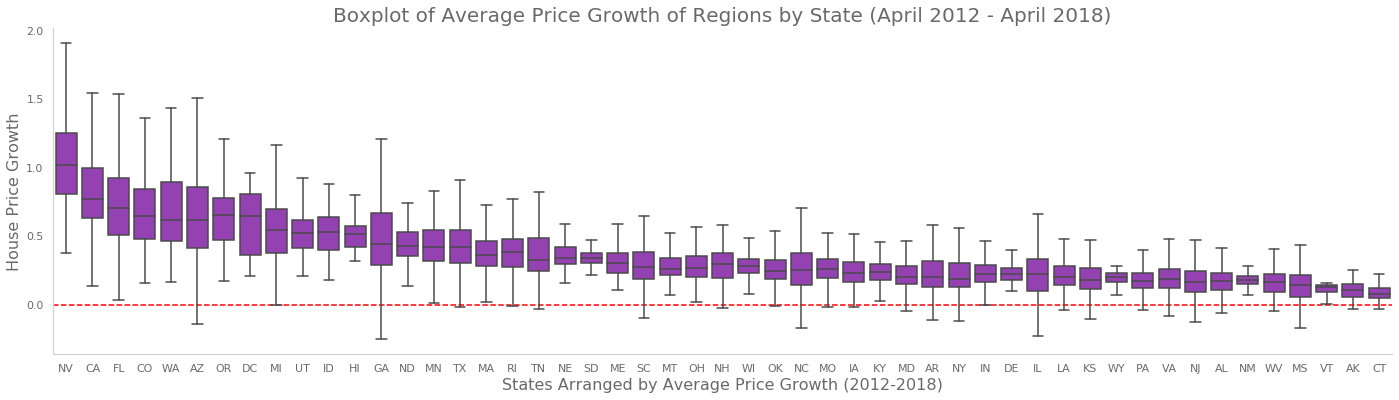

In [38]:
plt.figure(figsize=(24,6))
state_order = df_states['12-18%_mean'].sort_values(ascending=False).index
plt.axhline(0,color='red',ls='--')
sns.boxplot(x='State',y='12-18%',
           data=df_stats, order=state_order,
           showfliers=False, color = CB91_Purple)

plt.xlabel('States Arranged by Average Price Growth (2012-2018)')
plt.ylabel('House Price Growth')
plt.title('Boxplot of Average Price Growth of Regions by State (April 2012 - April 2018)')

In [39]:
#df_states['12-18%_mean'].sort_values(ascending=False)

## Data for population changes 

In [40]:
dfc_ = pd.read_csv('Data/nst-est-popchg2010_2019.csv')
dfc = dfc_.iloc[5:]   ####### Remove the region
dfc_region = dfc_.iloc[:5]

In [41]:
dfc_stats = dfc[list(dfc.columns[:16])]
dfc_stats = dfc_stats.drop(columns=['SUMLEV','REGION','DIVISION','ESTIMATESBASE2010','STATE'])
dfc_stats['Incresement%'] = dfc_stats['POPESTIMATE2019'] / dfc_stats['POPESTIMATE2010'] - 1
#dfc_stats['Incresement%'] 
#region = dfc_stats.head()

In [42]:
dfc_R = dfc_region[list(dfc_region.columns[:16])]
dfc_R = dfc_R.drop(columns=['SUMLEV','REGION','DIVISION','ESTIMATESBASE2010','STATE'])
dfc_R['Incresement%'] = dfc_R['POPESTIMATE2019'] / dfc_R['POPESTIMATE2010'] - 1
region = dfc_R.head()

Text(0.5, 1.0, 'Boxplot of Average Price Growth of Regions by State (April 2012 - April 2018)')

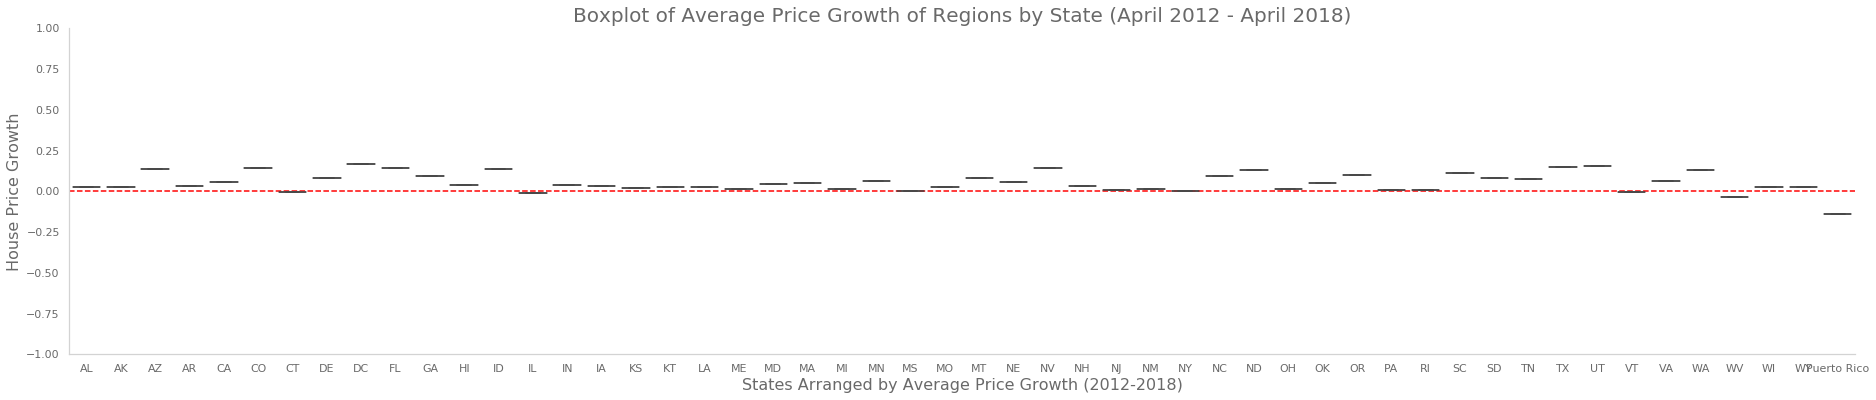

In [43]:
plt.figure(figsize=(32,6))
#change_order = dfc_stats['Incresement%'].sort_values(ascending=False)
plt.axhline(0,color='red',ls='--')
sns.boxplot(x='NAME',y='Incresement%',
           data=dfc_stats, 
           showfliers=False, color = CB91_Purple)
plt.ylim(-1,1)
plt.xlabel('States Arranged by Average Price Growth (2012-2018)')
plt.ylabel('House Price Growth')
plt.title('Boxplot of Average Price Growth of Regions by State \
(April 2012 - April 2018)')

Text(0.5, 1.0, 'Boxplot of Average Price Growth of Regions by State (April 2012 - April 2018)')

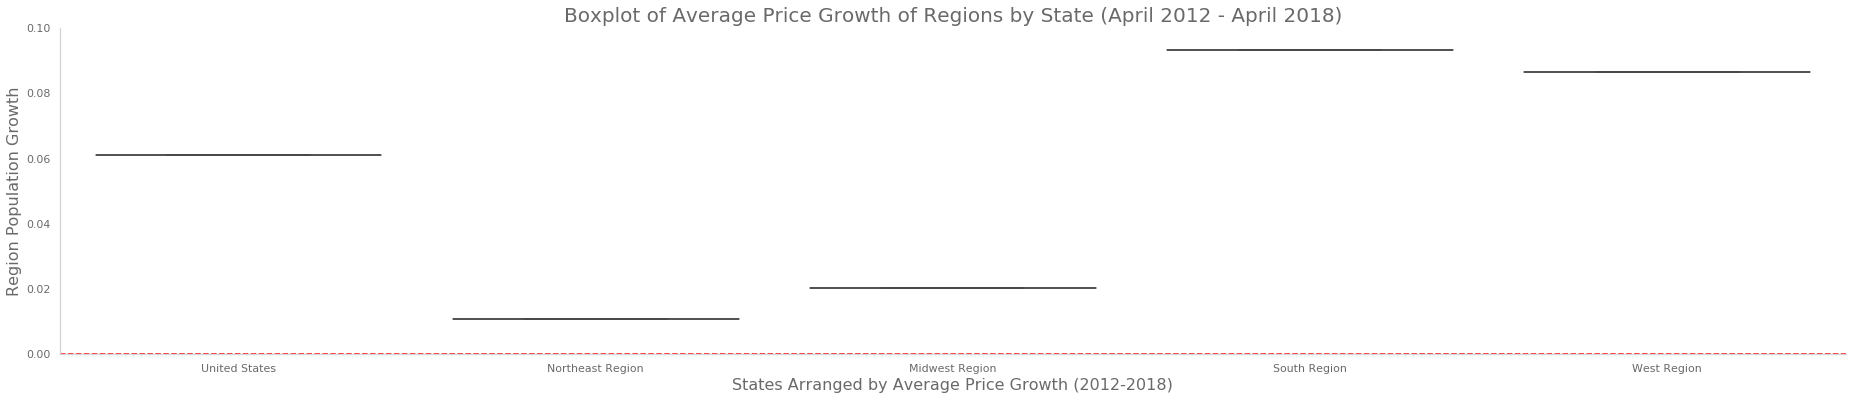

In [44]:
plt.figure(figsize=(32,6))
#change_order = dfc_stats['Incresement%'].sort_values(ascending=False)
plt.axhline(0,color='red',ls='--')
sns.boxplot(x='NAME',y='Incresement%',
           data=region, 
           showfliers=False, color = CB91_Purple)
plt.ylim(0,0.1)
plt.xlabel('States Arranged by Average Price Growth (2012-2018)')
plt.ylabel('Region Population Growth')
plt.title('Boxplot of Average Price Growth of Regions by State \
(April 2012 - April 2018)')

In [45]:
tmp = dfc_stats[5:60]
#tmp_stats.set_index("NAME", inplace = True)
tmp.head()
#tmp_stats.loc['Iowa']['Incresement%']
#df_temp = df_temp.dropna()
#tmp_stats['Incresement%']
states = list(tmp.index)

In [46]:
dfc_stats[0:56]

,NAME,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,Incresement%
5,AL,4785437,4799069,4815588,4830081,4841799,4852347,4863525,4874486,4887681,4903185,0.024605
6,AK,713910,722128,730443,737068,736283,737498,741456,739700,735139,731545,0.024702
7,AZ,6407172,6472643,6554978,6632764,6730413,6829676,6941072,7044008,7158024,7278717,0.136026
8,AR,2921964,2940667,2952164,2959400,2967392,2978048,2989918,3001345,3009733,3017804,0.032800
9,CA,37319502,37638369,37948800,38260787,38596972,38918045,39167117,39358497,39461588,39512223,0.058755
10,CO,5047349,5121108,5192647,5269035,5350101,5450623,5539215,5611885,5691287,5758736,0.140943
11,CT,3579114,3588283,3594547,3594841,3594524,3587122,3578141,3573297,3571520,3565287,-0.003863
12,DE,899593,907381,915179,923576,932487,941252,948921,956823,965479,973764,0.082450
13,DC,605226,619800,634924,650581,662328,675400,685815,694906,701547,705749,0.166092
14,FL,18845537,19053237,19297822,19545621,19845911,20209042,20613477,20963613,21244317,21477737,0.139672


In [47]:
tmp_stats = dfc_stats[0:51]
tmp_stats = tmp_stats.sort_values('NAME')
df_states['Incresement%'] = list(tmp_stats['Incresement%'])



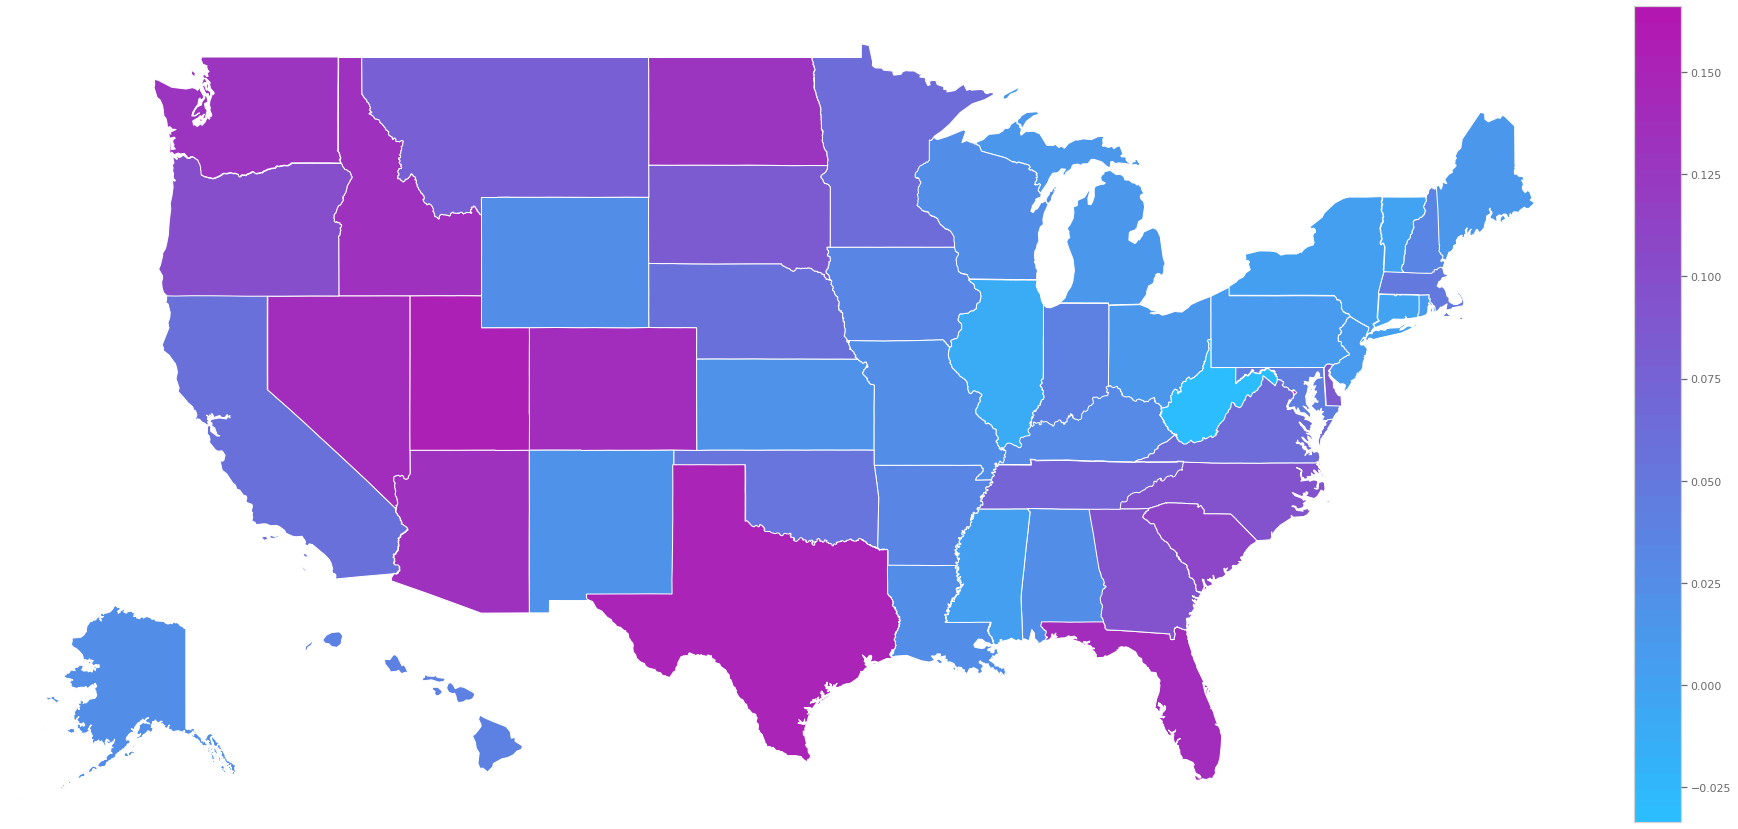

In [48]:
state_map('Incresement%',grad=CB91_Grad_BP,annot=False)

In [50]:
#Initiate an empty list for the regionIDs with extreme growth
extreme_codes = []

#Find the regions that had the biggest growth in each time period
extreme_codes.append(df_stats.sort_values(
    '96-07%').dropna().iloc[0]['RegionID'])

extreme_codes.append(df_stats.sort_values(
    '07-12%').dropna().iloc[0]['RegionID'])

extreme_codes.append(df_stats.sort_values(
    '12-18%').dropna().iloc[0]['RegionID'])

#And the regions that had the biggest falls
extreme_codes.append(df_stats.sort_values(
    '96-07%', ascending = False).dropna().iloc[0]['RegionID'])

extreme_codes.append(df_stats.sort_values(
    '07-12%', ascending = False).dropna().iloc[0]['RegionID'])

extreme_codes.append(df_stats.sort_values(
    '12-18%', ascending = False).dropna().iloc[0]['RegionID'])

#Create a dataframe that looks at these regions
df_extreme = df.loc[df['RegionID'].isin(extreme_codes)]

#Create a new column of county name, state name, which we'll use as an index
df_extreme['Index'] = df_extreme["CountyName"].map(
    lambda x: f'{str(x)}, ') + df_extreme["State"]

df_extreme.set_index('Index', inplace=True)

#Transpose to create line plots, then we can plot all the timelines
df_extreme = df_extreme.iloc[:,8:].T

In [51]:
df_extreme

Index,"Alameda, CA","Travis, TX","Wayne, MI","Cambria, PA","Sussex, DE","Northumberland, PA"
1996-05-01,114500.0,765800.0,68200.0,43200.0,34900.0,39300.0
1996-06-01,114500.0,760200.0,68500.0,43300.0,35200.0,39500.0
1996-07-01,114400.0,755200.0,68800.0,43400.0,35700.0,39600.0
1996-08-01,114400.0,751100.0,69200.0,43600.0,36100.0,39700.0
1996-09-01,114400.0,747800.0,69500.0,43800.0,36500.0,39800.0
...,...,...,...,...,...,...
2017-12-01,535800.0,473200.0,71000.0,27600.0,269300.0,125500.0
2018-01-01,546900.0,473500.0,72300.0,27600.0,272100.0,126600.0
2018-02-01,555000.0,475500.0,73500.0,27700.0,275300.0,127600.0
2018-03-01,562000.0,479300.0,75300.0,28300.0,277000.0,128400.0


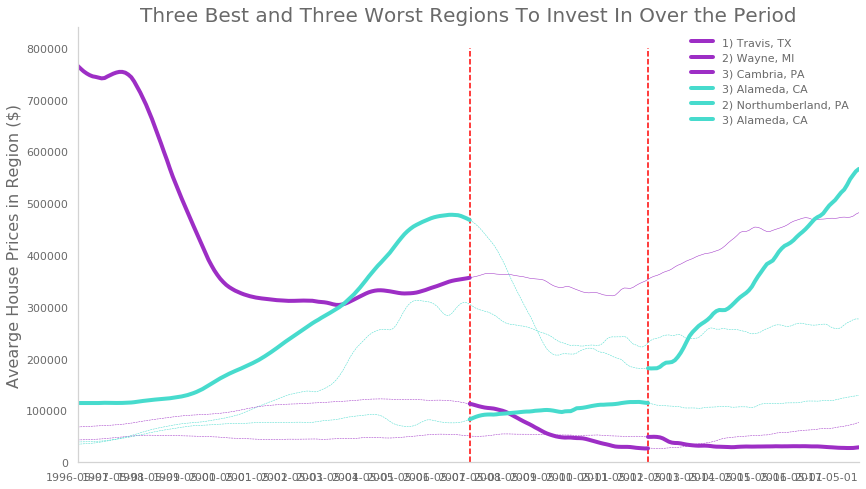

In [52]:
#Now plot the regions' prices over time...
plt.figure(figsize=(14,8))
#When a csv file is imported and a Data Frame is made, 
#the Date time objects in the file are read as a string object 
#rather a Date Time object and Hence it’s very tough to 
#perform operations like Time difference on a string rather a Date Time object. 
#Pandas to_datetime() method helps to convert string Date time into Python Date time object.
x = pd.to_datetime(df_extreme.index)
x1 = pd.to_datetime(df_extreme.index[:133])
x2 = pd.to_datetime(df_extreme.index[132:193])
x3 = pd.to_datetime(df_extreme.index[192:])

plt.plot(x, df_extreme['Travis, TX'], color = CB91_Purple,
         lw = 0.5,  label = '')
plt.plot(x, df_extreme['Cambria, PA'], color = CB91_Purple,
         lw = 0.5, ls = '--', label = '')
plt.plot(x, df_extreme['Sussex, DE'], color = CB91_Green,
         lw = 0.5, ls = '--', label = '')
plt.plot(x, df_extreme['Northumberland, PA'], color = CB91_Green,
         lw = 0.5, ls = '--', label = '')
plt.plot(x, df_extreme['Alameda, CA'], color = CB91_Green,
         lw = 0.5, ls = '--', label = '')
plt.plot(x, df_extreme['Wayne, MI'], color = CB91_Purple,
         lw = 0.5, ls = '--', label = '')


plt.plot(x1, df_extreme['Travis, TX'][x1], color = CB91_Purple,
         lw = 4, label = '1) Travis, TX')
plt.plot(x2, df_extreme['Wayne, MI'][x2], color = CB91_Purple,
         lw = 4, label = '2) Wayne, MI')
plt.plot(x3, df_extreme['Cambria, PA'][x3], color = CB91_Purple,
         lw = 4, label = '3) Cambria, PA')
plt.plot(x1, df_extreme['Alameda, CA'][x1], color = CB91_Green,
         lw = 4, label = '3) Alameda, CA')
plt.plot(x2, df_extreme['Northumberland, PA'][x2], color = CB91_Green,
         lw = 4, label = '2) Northumberland, PA')
plt.plot(x3, df_extreme['Alameda, CA'][x3], color = CB91_Green,
         lw = 4, label = '3) Alameda, CA')



plt.vlines([x1[0],x2[0],x3[0]],0,800000,color='red',linestyles='dashed')
plt.xticks([x[i] for i in range(len(df_extreme)) if i%12 == 0])
plt.xlim(x[0],x[-1]);
plt.ylim(0,);

plt.legend(frameon=False)##### No frame line for legend

plt.title('Three Best and Three Worst Regions \
To Invest In Over the Period');
plt.ylabel('Avearge House Prices in Region ($)');

In [53]:
CHI = df.loc[(df['City'] == 'Chicago') & (df['State'] == 'IL')]
LA = df.loc[(df['City'] == 'Los Angeles') & (df['State'] == 'CA')]
HOU = df.loc[(df['City'] == 'Houston') & (df['State'] == 'TX')]
NYC = df.loc[(df['City'] == 'New York') & (df['State'] == 'NY')]
PHX = df.loc[(df['City'] == 'Phoenix') & (df['State'] == 'AZ')]
PHI = df.loc[(df['City'] == 'Philadelphia') & (df['State'] == 'PA')]
ATL = df.loc[(df['City'] == 'Atlanta') & (df['State'] == 'GA')]
SF = df.loc[(df['City'] == 'San Francisco') & (df['State'] == 'CA')]
DAL = df.loc[(df['City'] == 'Dallas') & (df['State'] == 'TX')]
MIA = df.loc[(df['City'] == 'Miami') & (df['State'] == 'FL')]

CHI_mean = CHI.groupby(['State','City']).mean()
LA_mean = LA.groupby(['State','City']).mean()
HOU_mean = HOU.groupby(['State','City']).mean()
NYC_mean = NYC.groupby(['State','City']).mean()
PHX_mean = PHX.groupby(['State','City']).mean()
ATL_mean = ATL.groupby(['State','City']).mean()
PHI_mean = PHI.groupby(['State','City']).mean()
SF_mean = SF.groupby(['State','City']).mean()
DAL_mean = DAL.groupby(['State','City']).mean()
MIA_mean = MIA.groupby(['State','City']).mean()


In [54]:
ASD = pd.concat([CHI_mean,LA_mean,HOU_mean,NYC_mean,PHX_mean,ATL_mean,PHI_mean,SF_mean,DAL_mean,MIA_mean], axis=0)

ASD.reset_index(inplace=True)
#ATL_mean = ATL_mean.rename(columns = {'index':'Atlanta,GA'})
ASD.index = ASD["City"] +','+ ASD["State"]
ASD = ASD.iloc[:,6:].T
ASD

,State,City,RegionID,RegionName,SizeRank,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
"Chicago,IL",IL,Chicago,92510.450000,60633.650000,1295.550000,176757.500000,177220.000000,177500.000000,177560.000000,177435.000000,...,4.442775e+05,4.448425e+05,4.452275e+05,4.463075e+05,4.478200e+05,4.488575e+05,4.504950e+05,4.521425e+05,4.527350e+05,4.518950e+05
"Los Angeles,CA",CA,Los Angeles,96168.268817,90583.354839,2470.129032,223764.516129,223833.333333,223873.118280,223898.924731,223966.666667,...,9.693613e+05,9.787656e+05,9.893602e+05,9.982849e+05,1.005139e+06,1.012359e+06,1.020692e+06,1.028884e+06,1.036853e+06,1.041249e+06
"Houston,TX",TX,Houston,91708.686047,77065.069767,3617.802326,162930.232558,163151.162791,163390.697674,163667.441860,163972.093023,...,2.546965e+05,2.554965e+05,2.565698e+05,2.578395e+05,2.588360e+05,2.596267e+05,2.603733e+05,2.618570e+05,2.641558e+05,2.657326e+05
"New York,NY",NY,New York,61994.571429,11076.303571,2815.857143,214819.230769,215233.653846,215698.076923,216186.538462,216720.192308,...,1.177211e+06,1.181146e+06,1.184312e+06,1.186848e+06,1.186939e+06,1.187824e+06,1.193012e+06,1.196839e+06,1.198353e+06,1.200188e+06
"Phoenix,AZ",AZ,Phoenix,103736.735294,85075.029412,3297.617647,115185.294118,115929.411765,116670.588235,117402.941176,118102.941176,...,3.041206e+05,3.064735e+05,3.088324e+05,3.111912e+05,3.131118e+05,3.149853e+05,3.167941e+05,3.185382e+05,3.206912e+05,3.225882e+05
"Atlanta,GA",GA,Atlanta,71039.250000,30319.916667,3810.416667,196991.666667,198000.000000,199033.333333,200083.333333,201183.333333,...,5.622667e+05,5.643333e+05,5.685917e+05,5.722833e+05,5.755000e+05,5.804167e+05,5.857750e+05,5.902167e+05,5.956333e+05,5.986750e+05
"Philadelphia,PA",PA,Philadelphia,65798.171429,19130.971429,3239.085714,77551.428571,77551.428571,77542.857143,77500.000000,77454.285714,...,2.394629e+05,2.413200e+05,2.435371e+05,2.456086e+05,2.475486e+05,2.492657e+05,2.507800e+05,2.524200e+05,2.547371e+05,2.565571e+05
"San Francisco,CA",CA,San Francisco,97573.631579,94119.368421,1827.105263,394605.263158,396078.947368,397673.684211,399410.526316,401252.631579,...,2.053126e+06,2.059911e+06,2.072579e+06,2.091211e+06,2.099442e+06,2.103574e+06,2.111747e+06,2.120553e+06,2.134005e+06,2.146479e+06
"Dallas,TX",TX,Dallas,90782.750000,75231.093750,3177.468750,181215.625000,181121.875000,181084.375000,181125.000000,181275.000000,...,3.378406e+05,3.400969e+05,3.433125e+05,3.449469e+05,3.440062e+05,3.433875e+05,3.445594e+05,3.470156e+05,3.502938e+05,3.526438e+05
"Miami,FL",FL,Miami,72437.666667,33134.666667,2963.333333,130211.111111,130155.555556,130088.888889,130000.000000,129955.555556,...,4.773333e+05,4.796000e+05,4.851333e+05,4.891556e+05,4.896333e+05,4.905111e+05,4.936111e+05,4.962778e+05,4.990000e+05,5.012889e+05


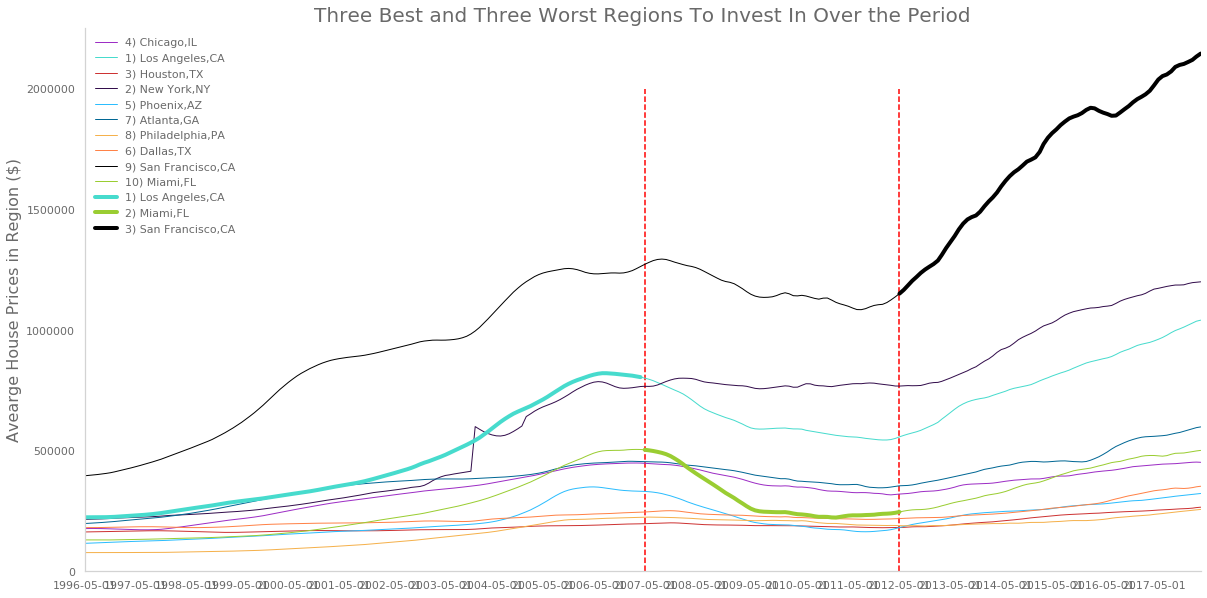

In [56]:
plt.figure(figsize=(20,10))

x = pd.to_datetime(ASD.index)
x1 = pd.to_datetime(ASD.index[:132])
x2 = pd.to_datetime(ASD.index[132:193])
x3 = pd.to_datetime(ASD.index[192:])
######## x must have same length with ASD rows.  ########
plt.plot(x, ASD['Chicago,IL'], color = CB91_Purple,
         lw = 1,  label = '4) Chicago,IL')
plt.plot(x, ASD['Los Angeles,CA'], color = CB91_Green,
         lw = 1,  label = '1) Los Angeles,CA')
plt.plot(x, ASD['Houston,TX'], color = CB91_Crimson,
         lw = 1,  label = '3) Houston,TX')
plt.plot(x, ASD['New York,NY'], color = CB91_VioletD,
         lw = 1,  label = '2) New York,NY')
plt.plot(x, ASD['Phoenix,AZ'], color = CB91_Blue,
         lw = 1,  label = '5) Phoenix,AZ')
plt.plot(x, ASD['Atlanta,GA'], color = CB91_BlueD,
         lw = 1,  label = '7) Atlanta,GA')
plt.plot(x, ASD['Philadelphia,PA'], color = CB91_Amber,
         lw = 1,  label = '8) Philadelphia,PA')
plt.plot(x, ASD['Dallas,TX'], color = CB91_Orange,
         lw = 1,  label = '6) Dallas,TX')
plt.plot(x, ASD['San Francisco,CA'], color = CB91_Black,
         lw = 1,  label = '9) San Francisco,CA')
plt.plot(x, ASD['Miami,FL'], color = CB91_Oliver,
         lw = 1,  label = '10) Miami,FL')


plt.plot(x1, ASD['Los Angeles,CA'][x1], color = CB91_Green,
         lw = 4, label = '1) Los Angeles,CA')
plt.plot(x2, ASD['Miami,FL'][x2],color = CB91_Oliver,lw=4,label='2) Miami,FL')
plt.plot(x3, ASD['San Francisco,CA'][x3],color = CB91_Black,lw=4,label='3) San Francisco,CA')

plt.vlines([x1[0],x2[0],x3[0]],0,2000000,color='red',linestyles='dashed')
plt.xticks([x[i] for i in range(len(ASD)) if i%12 ==0])
#plt.xticks([x[i] for i in range(len(df_extreme)) if i%12 == 0])
plt.xlim(x[0],x[-1]);
plt.ylim(0,);

plt.legend(frameon=False)##### No frame line for legend

plt.title('Three Best and Three Worst Regions To Invest In Over the Period');
plt.ylabel('Avearge House Prices in Region ($)');

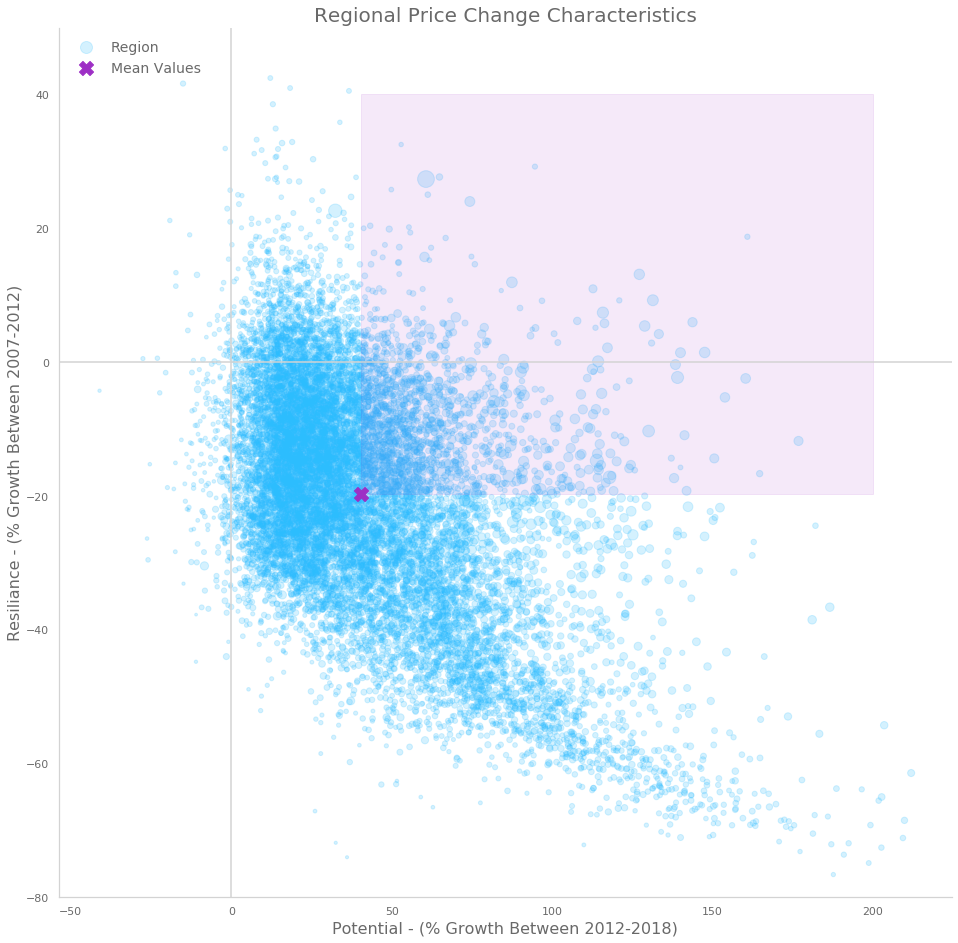

In [115]:
#translate the current house price values
#this will be used to size the points on the scatter
trans_values = np.sqrt(df_stats['Apr18'])/15

#calculate the average x and y values
avg_res = df_stats['07-12%'].mean()
avg_pot = df_stats['12-18%'].mean()

plt.figure(figsize=(16,16))

#plot the scatter
plt.scatter(df_stats['12-18%'] * 100, df_stats['07-12%'] * 100,
            s=trans_values, alpha=0.2, label='Region');

#and plot a point showing the average
plt.scatter(avg_pot * 100, avg_res * 100, s=200,
            color=CB91_Purple, marker='X', label='Mean Values');

#shade the region that is above both averages
plt.fill_between([avg_pot*100, 200], [avg_res*100, avg_res*100], [40,40],
        color=CB91_Purple, alpha=0.1)

plt.axhline(0,color='lightgrey')
plt.axvline(0,color='lightgrey')

plt.ylim(-80,50)

plt.legend(loc=2, frameon=False, fontsize=14)

plt.title('Regional Price Change Characteristics')
plt.xlabel('Potential - (% Growth Between 2012-2018)');
plt.ylabel('Resiliance - (% Growth Between 2007-2012)');

In [116]:
df_stats_growth = df_stats.loc[(df_stats['07-12%']>avg_res) &
                               (df_stats['12-18%']>avg_pot)]
growth_regions = list(df_stats_growth['RegionID'])

#Add a column to the original dataframe to see
#if the region is in the growth group or not
df['GrowthRegion'] = df['RegionID'].map(lambda x: 1 if x in growth_regions else 0)

cols = list(df.columns)
df = df[cols[:7] + [cols[-1]] + cols[7:-1]]   ###### Remove the last column
###########. df[cols[7:272]] == df[cols[7:-1]]

In [117]:
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2018-04-01 00:00:00,GrowthRegion,1996-04-01 00:00:00,...,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00
0,84654,60657,Chicago,IL,Chicago,Cook,1,1030600,0,334200.0,...,999100,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,321800,1,235700.0,...,307000,308000,310000,312500,314100,315000,316600,318100,319600,321100
2,91982,77494,Katy,TX,Houston,Harris,3,329900,0,210400.0,...,320900,321000,320600,320200,320400,320800,321200,321200,323000,326900
3,84616,60614,Chicago,IL,Chicago,Cook,4,1307000,0,498100.0,...,1289000,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500
4,93144,79936,El Paso,TX,El Paso,El Paso,5,121500,0,77300.0,...,118900,119100,119400,120000,120300,120300,120300,120300,120500,121000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,209300,0,94600.0,...,215400,216800,217700,218600,218500,218100,216400,213100,209800,209200
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,225800,0,92700.0,...,197300,202100,208400,212200,215200,214300,213100,213700,218300,222700
14720,75672,40404,Berea,KY,Richmond,Madison,14721,133400,0,57100.0,...,121100,121800,122800,124600,126700,128800,130600,131700,132500,133000
14721,93733,81225,Mount Crested Butte,CO,Not known,Gunnison,14722,664400,0,191100.0,...,647300,662800,671200,682400,695600,695500,694700,706400,705300,681500


In [58]:
def indexed_time_series(start,df=df,drop_na=True):
    
    '''
    Takes a point in time 'start', and returns a dataframe
    that indexes all house prices to this start time (which is indexed to 100) 
    '''
    
    start = pd.to_datetime(start, format='%Y-%m')
    new_df = df[['RegionID','State','GrowthRegion']]
    for i in df.columns[8:]:
        new_df[i] = 100 *(df[i] / df[start])
    
    #If drop_na is true, then drop all regions with any NAs
    if drop_na:
        new_df = new_df.dropna()
    
    return new_df

In [59]:
df_07_indexed = indexed_time_series('2007-04')

df_sum['Growth_Index'] = list(df_07_indexed.loc[df_07_indexed['RegionID'].isin(
    growth_regions)].median()[2:])

df_sum['Non_Growth_Index'] = list(df_07_indexed.loc[~df_07_indexed['RegionID'].isin(
    growth_regions)].median()[2:])

In [76]:
df_sum

,index,Mean,Min,05%,25%,50%,75%,95%,Max,Growth_Index,Non_Growth_Index
0,1996-04-01,118299.123063,11300,40400.0,68800.0,99500.0,143200.0,254500.0,3.6767e+06,58.341284,48.079849
1,1996-05-01,118419.044139,11500,40500.0,68900.0,99500.0,143300.0,254700.0,3.7042e+06,58.456629,48.144152
2,1996-06-01,118537.423268,11600,40600.0,69100.0,99700.0,143225.0,254700.0,3.7296e+06,58.485762,48.247884
3,1996-07-01,118653.069278,11800,40700.0,69200.0,99700.0,143225.0,255100.0,3.7546e+06,58.646896,48.368250
4,1996-08-01,118780.254312,11800,40800.0,69375.0,99800.0,143500.0,255300.0,3.7818e+06,58.767046,48.413671
...,...,...,...,...,...,...,...,...,...,...,...
260,2017-12-01,287190.682833,14300,76000.0,133500.0,198600.0,320700.0,758000.0,18307100,136.457828,101.848412
261,2018-01-01,288804.481316,14100,76210.0,134100.0,199500.0,322600.0,762090.0,18365900,136.941891,102.184038
262,2018-02-01,290560.306318,13900,76700.0,134700.0,200600.0,324350.0,766410.0,18530400,137.951412,102.670425
263,2018-03-01,292744.160817,13800,77310.0,135500.0,202400.0,326300.0,771680.0,18337700,139.412941,103.410903


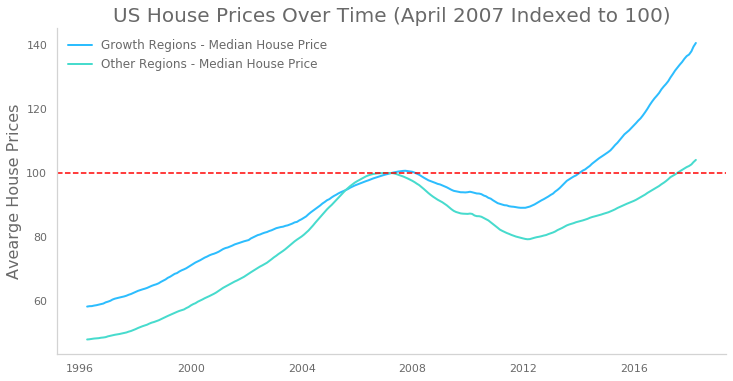

In [60]:

plt.figure(figsize=(12,6))

x = df_sum['index']

plt.plot(x, df_sum['Growth_Index'], lw = 2,
         label = 'Growth Regions - Median House Price')

plt.plot(x, df_sum['Non_Growth_Index'], lw = 2,
         label = 'Other Regions - Median House Price')

plt.axhline(100,color='red',ls="--")

plt.legend(fontsize=12, loc=2, frameon=False);

plt.title('US House Prices Over Time (April 2007 Indexed to 100)')
plt.ylabel("Avearge House Prices");

plt.xlim();

In [96]:
df_rise = df.loc[df['GrowthRegion']==1]
df_fall = df.loc[df['GrowthRegion']==0]
df_fall

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,GrowthRegion,1996-04-01 00:00:00,1996-05-01 00:00:00,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
0,84654,60657,Chicago,IL,Chicago,Cook,1,0,334200.0,335400.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
2,91982,77494,Katy,TX,Houston,Harris,3,0,210400.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,0,498100.0,500900.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
6,61807,10467,New York,NY,New York,Bronx,7,0,152900.0,152700.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,0,94600.0,94300.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,0,92700.0,92500.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,0,57100.0,57300.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,Not known,Gunnison,14722,0,191100.0,192400.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


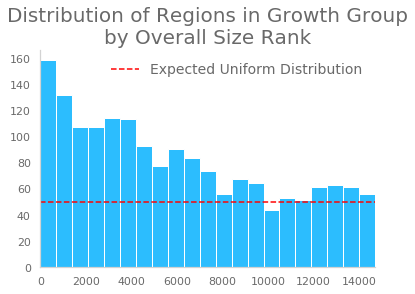

In [89]:

plt.hist(df_growth['SizeRank'], bins = 21)
plt.axhline(50,color='red',
            ls="--",label='Expected Uniform Distribution');
plt.xlim(0,df_growth['SizeRank'].max())
plt.legend(frameon=False, fontsize=14)
plt.title('Distribution of Regions in Rise Group\nby Overall Size Rank');

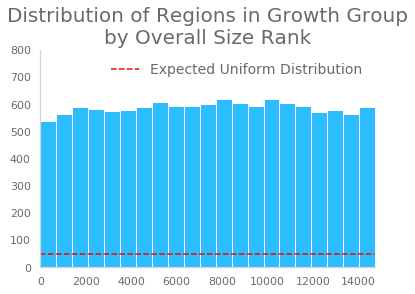

In [95]:
plt.hist(df_fall['SizeRank'], bins = 21)
plt.axhline(50,color='red',ls='--',label='Expected Uniform Distribution')
plt.xlim(0,df_fall['SizeRank'].max())
plt.ylim(0,800)
plt.legend(frameon=False, fontsize=14)
plt.title('Distribution of Regions in Fall Group\nby Overall Size Rank');

In [63]:
#The number of growth regions in the state
df_states['GrowthRegions'] = df.groupby('State').sum()['GrowthRegion']

#The share of state regions that are growth regions
df_states['%GrowthRegions'] = df_states['GrowthRegions'] \
/ df_states['RegionCount']


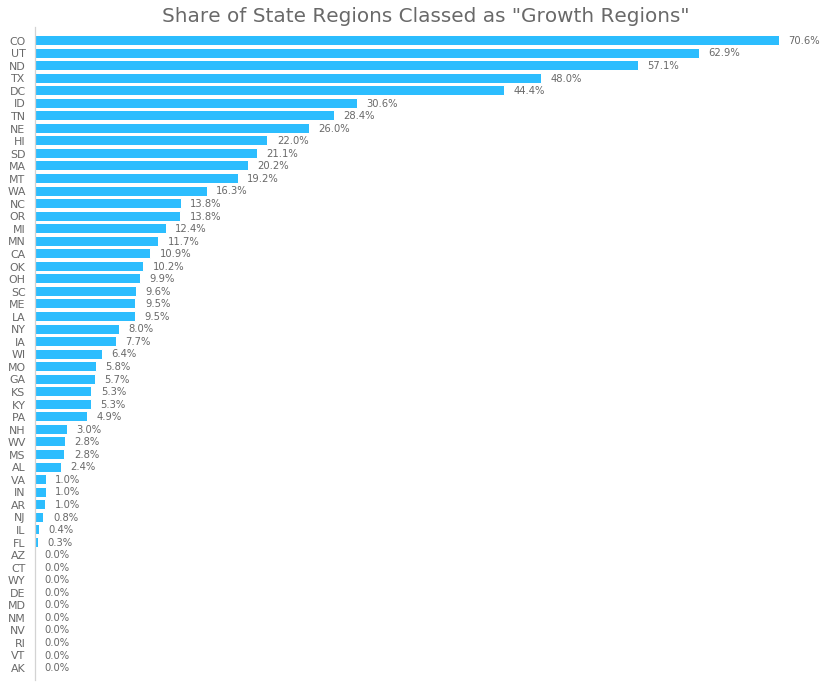

In [132]:
#Plot the share of state regions classed as growth regions
plt.figure(figsize=(14,12))

df_states_ordered = df_states.sort_values('%GrowthRegions')

plt.barh(df_states_ordered.index,df_states_ordered['%GrowthRegions'],height=0.8)

sns.despine(bottom=True)
plt.xticks([])     #######.  Remove X axis
plt.ylim(-1,51)

plt.title('Share of State Regions Classed as "Growth Regions"')

for i, v in enumerate(df_states_ordered['%GrowthRegions']):
    plt.text(v+0.009, i - 0.25, f'{str(round(v*100,1))}%', fontsize = 10)

In [65]:
#state_map('GrowthRegions',grad=CB91_Grad_BP,annot=False)
#state_map('%GrowthRegions',grad=CB91_Grad_BP,annot=False)


# Modeling

In [413]:
def ts_filter(regions, start = '1996-04', end = '2018-04', df = df):
    
    '''
    Takes a list of regions, a start date, and and end date,
    and returns a time series dataframe with a region given in each column
    
    Parameters:
    - regions (list): The regions we want to keep
    - start (str): The first date to include in the dataframe (pass as 'YYYY-MM')
    - end (str): The last date to include in the dataframe (pass as 'YYYY-MM')
    - df (pandas dataframe): The dataframe we want to use

    
    '''
    
    #Turn single entry into a list.
    #Allows user to enter a single regionID
    #if we just want to consider a single region
    if type(regions) != list:
        regions = [regions]
    
    #Change input dates to datetime objects
    start = pd.to_datetime(start, format='%Y-%m')
    end = pd.to_datetime(end, format='%Y-%m')
    
    #Create a new dataframe that filters regions,
    #and set the regionID to be the index
    df_temp = df.loc[df['RegionID'].isin(regions)]
    
    #We need to set the regionID to be a string
    #for the sake of the ARIMA modelling later
    df_temp['RegionID'] = df_temp['RegionID'].astype(str)
    df_temp.set_index(['RegionID'],inplace=True)

    #Find which columns the start and end dates represent in the dataframe
    columns = list(df_temp.columns)
    start_index = columns.index(start)
    end_index = columns.index(end)
    
    #Isolate the required dates in the dataframe
    #Transpose so that dates are the index
    df_temp = df_temp.iloc[:,start_index:end_index+1].T
    
    #We then need to reset the index, and set it back to the date
    #This ensures pandas treats the index elements as datetimes
    df_temp.reset_index(inplace=True)
    df_temp.set_index('index',inplace=True)
    
    return df_temp

In [414]:
dftest = adfuller(df_sum['50%'])
dftest2 = adfuller(df_sum['50%'][192:])
print(f'p-value for all data = {round(dftest[1],3)}')
print(f'p-value for data from April 2012 = {dftest2[1]}')

p-value for all data = 0.587
p-value for data from April 2012 = 1.0


In [415]:
dftest = adfuller(df_sum['Mean'])
dftest2 = adfuller(df_sum['Mean'][192:])
print(f'p-value for all data = {round(dftest[1],3)}')
print(f'p-value for data from April 2012 = {round(dftest2[1],3)}')


p-value for all data = 0.34
p-value for data from April 2012 = 0.998


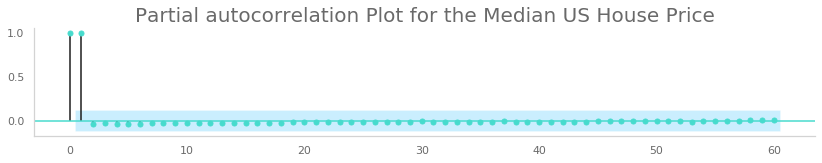

In [416]:
rcParams['figure.figsize'] = 14, 2
plot_pacf(df_sum['50%'], lags = 60, color=CB91_Green);
plt.title('Partial autocorrelation Plot for the Median US House Price');


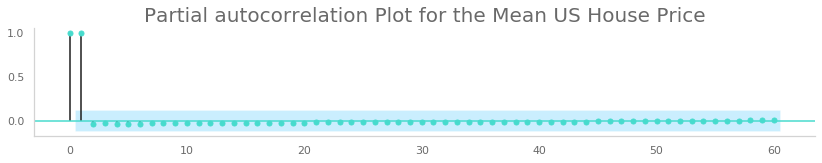

In [417]:

rcParams['figure.figsize'] = 14, 2
plot_pacf(df_sum['Mean'], lags = 60, color=CB91_Green);
plt.title('Partial autocorrelation Plot for the Mean US House Price');


In [418]:
#Define a standard series of parameters for the ARIMA model orders

p = q = d = [0,1,2]
d = [0,1]

combs = list(itertools.product(p,d,q))


def arima_selection(ts, combs=combs, split=0.9):
    
    '''
    Parameters
    - ts: The dataset that we want to fit to the model
    - Combs: The combinations of (p,d,q) that we want to consider
    - Split: The share of the dataset that we want to include in the train set
    
    Outputs:
    - The optimal (p,d,q) that minimises MSE on the test set
    - The fitted ARIMA model as an object
    '''
       #Calculate the index of the series that we'll use to do the train test split
    limit = int(len(ts) * split)
    
    #Create the train test series
    train = ts[:limit]
    test = ts[limit:]
    
    #Declare variables that we'll update and return later on
    rmse = None
    best_model = None
    best_order = None
    best_rmse = 10000000
    
    #Loop through the combinations...
    for i in combs:
        try:
            #Fit a model on the training set
            model = ARIMA(train,order=i)
            output = model.fit()
            #Predict forward the number equivalent to the length of the test set
            pred = output.forecast(len(test))[0]
            #Calculate the mean square error
            rmse = mean_squared_error(test, pred)**0.5
            
            #If we have a new best mse, then update the RMSE and model parameters
            if rmse < best_rmse:
                best_order = i
                best_rmse = rmse
                best_model = output

        except:
            continue
            
    if rmse == None:
        return None
    else:
        return best_order, best_model


In [419]:
def arima_forecast(output, periods):
    
    '''
    Parameters
    - output: A fitted statsmodel ARIMA model (as an object)
    - periods: The number of periods into the future that we want to forecast
    
    Outputs the fitted model as an object.
    Also outputs three series covering the number of
    periods set out in the parameters:
    1) the forecast
    2) lower bounds
    3) upper bounds
    '''

    #Calculate the forecast and isolate lower and upper bounds
    forecast = output.forecast(periods)
    lower = [i[0] for i in forecast[2]]
    upper = [i[1] for i in forecast[2]]

    return forecast[0], lower, upper


In [420]:
def arima_output(region, start='2012-04', periods = 120,
                 split = 0.9, combs = combs):
    
    '''
    Takes a region and produces a dataframe with a full output of statistics
    
    Parameters
    - region: The RegionID that we want to consider
    - start: The first date that we want to consider in the time series
    - periods: The number of periods into the future that we want to forecast
    - split: The share of the dataset that we want to include in the train set
    - combs: The combinations of (p,d,q) that we want to consider

    
    Outputs a one-row pandas dataframe with
    information about the ARIMA model for that region
    '''    
    
    ts = ts_filter(region,start=start)

    order, output = arima_selection(ts=ts, combs=combs, split=split)
    
    #Guard against cases where no model could be fit to the region's data
    if order == None:
        return None

    else:
        forecast, lower, upper = arima_forecast(output=output, periods=periods)

        state = df.loc[df['RegionID']==region]['State'].item()
        county = df.loc[df['RegionID']==region]['CountyName'].item()

        df_temp = pd.DataFrame({'RegionID':[region],
                                'County':[county],
                                'State':[state],
                                'Order':[order],
                                'FittedModel':[output],
                                'Forecast':[forecast],
                                'Lower':[lower],
                                'Upper':[upper]})

        return df_temp

In [421]:
def arima_dataframe(regions, start='2012-04',
                    periods = 120, split = 0.9, combs = combs):
    
    '''
    Takes a list of regions and and produces a
    dataframe with a full output of statistics
    
    Parameters
    - regions: A list of RegionIDs that we want to consider
    - start: The first date that we want to consider in the time series
    - periods: The number of periods into the future that we want to forecast
    - split: The share of the dataset that we want to include in the train set
    - combs: The combinations of (p,d,q) that we want to consider
    
    Outputs a pandas dataframe with information about
    the ARIMA model for each region in the list
    '''
    
    #Declare an empty dataframe
    df_temp = pd.DataFrame()
    
    #Iterate through the regions in the list and
    #get the stats from the arima_output function
    for i in regions:
        region_df = arima_output(i, start=start,
                                 periods=periods, split=split)
        df_temp = pd.concat([df_temp,region_df])
    
    return df_temp

In [423]:

#arima_df = arima_dataframe(growth_regions)

#with open('arima_df.pickle', 'wb') as f:
    #pickle.dump(arima_df, f, pickle.HIGHEST_PROTOCOL)
with open('data/arima_df.pickle', 'rb') as file:
    arima_df = pickle.load(file)

arima_df.reset_index(inplace=True, drop=True)
arima_df.head()


,RegionID,County,State,Order,FittedModel,Forecast,Lower,Upper
0,90668,Collin,TX,"(2, 0, 2)",<statsmodels.tsa.arima_model.ARMAResultsWrappe...,"[312143.40643119154, 314064.3150512036, 315783...","[311295.6384028486, 311722.3738888332, 311647....","[312991.17445953446, 316406.256213574, 319920...."
1,91733,Harris,TX,"(2, 0, 2)",<statsmodels.tsa.arima_model.ARMAResultsWrappe...,"[159747.67657177543, 160654.7091093458, 161428...","[159291.82129491118, 159377.0017145843, 159173...","[160203.5318486397, 161932.4165041073, 163683...."
2,91940,Harris,TX,"(1, 1, 2)",<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,"[168312.6330976554, 169293.82987167052, 170217...","[167829.78990906934, 168010.72145518934, 16795...","[168795.47628624146, 170576.9382881517, 172481..."
3,97564,San Francisco,CA,"(1, 0, 0)",<statsmodels.tsa.arima_model.ARMAResultsWrappe...,"[3763964.854690347, 3764029.6776224324, 376409...","[3695309.2818519226, 3666959.8050405267, 36452...","[3832620.427528771, 3861099.550204338, 3882951..."
4,62037,Kings,NY,"(0, 1, 0)",<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,"[855881.25, 860762.5, 865643.75, 870525.0, 875...","[841787.4753875756, 840830.8927980798, 841232....","[869975.0246124244, 880694.1072019202, 890054...."


In [424]:
arima_df['ARParams'] = arima_df['FittedModel'].map(lambda x: x.arparams)
arima_df['MAParams'] = arima_df['FittedModel'].map(lambda x: x.maparams)

arima_df['ModelAIC'] = arima_df['FittedModel'].map(lambda x: x.aic)
arima_df['ModelBIC'] = arima_df['FittedModel'].map(lambda x: x.bic)

arima_df['Modelpvals'] = arima_df['FittedModel'].map(lambda x: x.pvalues)

AttributeError: 'ARMAResults' object has no attribute '_use_t'

In [425]:

arima_df.dropna(inplace=True)

# Interpreting Results

In [426]:
arima_df['Abs5yGrowth'] = arima_df['Forecast'].map(lambda x: x[59] - x[0])
arima_df['%5yGrowth'] = arima_df['Forecast'].map(lambda x: x[59]/x[0] - 1)


arima_df['Abs10yGrowth'] = arima_df['Forecast'].map(lambda x: x[-1] - x[0])
arima_df['%10yGrowth'] = arima_df['Forecast'].map(lambda x: x[-1]/x[0] - 1)

arima_df.sort_values('%10yGrowth', ascending=False).head()


,RegionID,County,State,Order,FittedModel,Forecast,Lower,Upper,ARParams,MAParams,ModelAIC,ModelBIC,Abs5yGrowth,%5yGrowth,Abs10yGrowth,%10yGrowth
697,91559,McLennan,TX,"(2, 1, 2)",<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,"[105085.16463331353, 106901.1734661564, 108747...","[104367.73632177095, 104989.71156263929, 10534...","[105802.59294485611, 108812.6353696735, 112154...","[1.9942938153586824, -0.9943231187118033]","[-0.5247542618419677, -0.4749444172715242]",954.827173,967.780472,158176.647164,1.505223,416268.669026,3.961251
1111,93636,Pueblo,CO,"(2, 1, 2)",<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,"[175093.56282152238, 176050.004591286, 177070....","[174315.36467656653, 174066.62250669362, 17358...","[175871.76096647824, 178033.3866758784, 180557...","[1.998172978967835, -0.9982562280869269]","[-0.6538615273077499, -0.34613808266810625]",966.886500,979.839798,184659.581624,1.054634,692601.950925,3.955611
534,93024,Taylor,TX,"(2, 1, 2)",<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,"[103666.55164536668, 104669.46299205805, 10570...","[102985.0171392703, 102721.65165481692, 102162...","[104348.08615146305, 106617.27432929918, 10925...","[1.996450352572352, -0.9965002312455917]","[-0.31913000849885764, -0.6808695780517263]",949.603065,962.556364,126951.155822,1.224611,409965.252970,3.954653
1246,67605,Henrico,VA,"(2, 1, 2)",<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,"[207700.15958550357, 210464.26860853142, 21329...","[206566.1344282922, 207400.0451436887, 207820....","[208834.18474271495, 213528.49207337413, 21876...","[1.984523693502028, -0.9845767608187883]","[-0.4743004116739685, -0.5256972456083303]",1012.529304,1025.482603,249020.548360,1.198942,611791.729369,2.945553
16,90654,Dallas,TX,"(2, 1, 2)",<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,"[189611.71227933312, 191063.59600190615, 19255...","[189110.25389139703, 189715.50103860276, 19014...","[190113.1706672692, 192411.69096520953, 194967...","[1.9979015641823878, -0.9980095996742788]","[-0.5024620673463988, -0.4975379323065289]",910.953709,923.907007,169097.895107,0.891811,548569.693383,2.893121


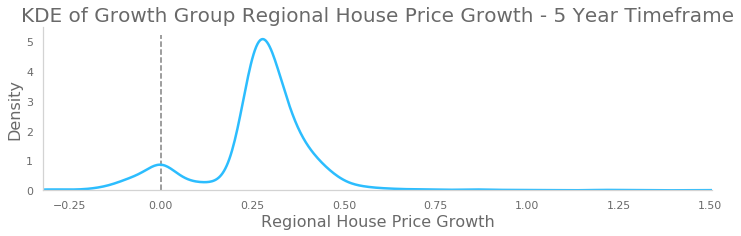

In [427]:
plt.figure(figsize=(12,3))
arima_df['%5yGrowth'].plot.kde(lw=2.5);
plt.vlines(0,0,5.2,color='grey',linestyles='dashed')

plt.xlim(arima_df['%5yGrowth'].min(),arima_df['%5yGrowth'].max())
plt.ylim(0,)

plt.title('KDE of Growth Group Regional House Price Growth - 5 Year Timeframe')
plt.xlabel('Regional House Price Growth');

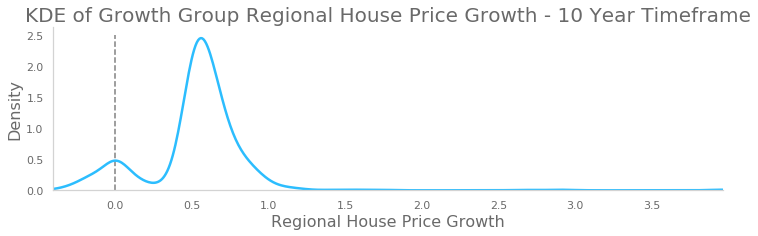

In [428]:
plt.figure(figsize=(12,3))
arima_df['%10yGrowth'].plot.kde(lw=2.5);
plt.vlines(0,0,2.5,color='grey',linestyles='dashed')

plt.xlim(arima_df['%10yGrowth'].min(),arima_df['%10yGrowth'].max())
plt.ylim(0,)

plt.title('KDE of Growth Group Regional House Price Growth - 10 Year Timeframe')
plt.xlabel('Regional House Price Growth');

In [429]:
def plot_forecasts(regions, labels=None, plot_range=True,
                   start='2012-04', months=120, size=(16,8)):
    
    '''
    Takes a list of region codes, and plots their forcasted house prices.
    
    Parameters
    - regions (list): a list of regionIDs that we
                      want to plot (can be single integer)
    - labels (list): desired labels for the legend
                     (state code added automatically)
    - plot_range(bool): if True, will plot the forecast
                        range with 95% conf interval
    - start (str): The first date to include in
                   the dataframe (pass as 'YYYY-MM')
    - months (int): the number of months of forecast we want to show
    - size (int,int): the desired size of the plot
    
    '''
    #If we pass a single integer, put it in a list
    if type(regions) != list:
        regions = [regions]
    
    #Initiate a figure
    plt.figure(figsize=size)
    
    #Initiate a color counter
    counter=0
    
    #Iterate through each region and plot one by one
    for i in regions:
        #Find the non-forecasted part
        ts_real = ts_filter(i).iloc[:-8,:]
        x_real = list(ts_real.index)
        y_real = ts_real

        #Work out how much we need to extend the x axis for the forecasts
        x_forecast = pd.date_range('2017-09-01', periods=months, freq='MS')
        
        #Identify the region, and plot it using the color from color list
        region_i = arima_df.loc[arima_df['RegionID']==i]
        
        #Specify the label
        if labels == None:
            label = f"{region_i['County'].item()} County, {region_i['State'].item()}"
        else:
            label = f"{labels[counter]}, {region_i['State'].item()}"
        
        y_forecast = region_i['Forecast'].item()[:months]

        color = color_list[counter]
        
        plt.plot(x_real, y_real, color=color, label = label, lw = 3)
        plt.plot(x_forecast,y_forecast, color=color, ls='--', label = '', lw = 3)
        
        #If we are showing ranges, find and plot these
        if plot_range==True:
            y_lower = region_i['Lower'].item()[:months]
            y_upper = region_i['Upper'].item()[:months]
            plt.fill_between(x_forecast, y_lower, y_upper,
                 facecolor=color, alpha = 0.15, interpolate=True)
        
        counter += 1

    plt.title('Price Forecasts (Limits Given to 95% Confidence Interval)')
    plt.ylabel('Avearge House Prices in Region ($)');
    
    plt.xlim(pd.to_datetime('2012-04', format='%Y-%m'),x_forecast[-1])
    plt.ylim(0,)

    plt.legend(loc=2, fontsize=14, frameon=False);

TypeError: float() argument must be a string or a number, not 'Timestamp'

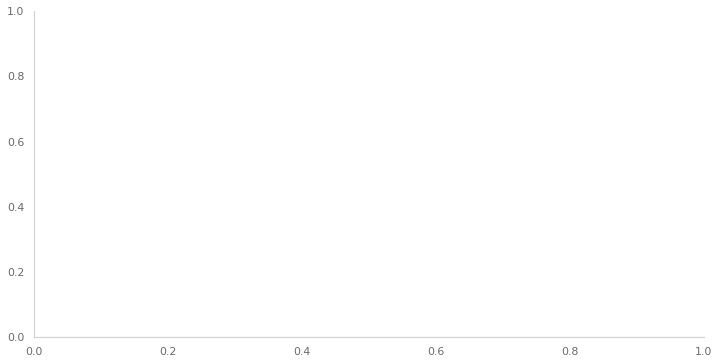

In [449]:
high_growth = list(arima_df.sort_values('%10yGrowth',ascending=False)['RegionID'][:5])
plot_forecasts((high_growth[1]), size=(12,6))

In [432]:
def forecast_width(regionID):
    
    '''
    Takes a regionID and returns the difference between the forecast's
    upper and lower estimates (at 95% confidence intervals) as
    a percentage of the average forecast
    '''
    #Isolate the region
    region = arima_df.loc[arima_df['RegionID']==regionID]

    #Find the forecast and lower/upper limits for the last forecasted period
    y_forecast = region['Forecast'].item()[-1]
    y_lower = region['Lower'].item()[-1]
    y_upper = region['Upper'].item()[-1]
    
    return (y_upper - y_lower) / y_forecast

arima_df['ForecastWidth'] = arima_df['RegionID'].map(
    lambda x: forecast_width(x))

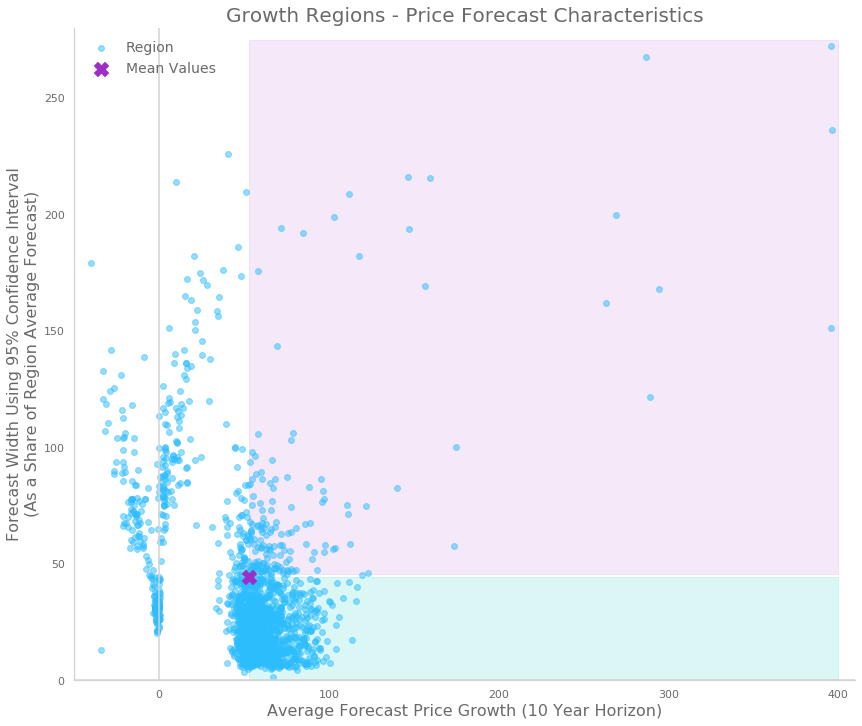

In [433]:
#calculate the average x and y values
avg_x = arima_df['%10yGrowth'].mean()
avg_y = arima_df['ForecastWidth'].mean()

plt.figure(figsize=(14,12))

# shade the region that is above both averages
plt.fill_between([avg_x*100, 400], [0,0], [avg_y*100, avg_y*100],
        color=CB91_Green, alpha=0.2)

plt.fill_between([avg_x*100, 400], [avg_y*100+1, avg_y*100+1], [275,275], 
        color=CB91_Purple, alpha=0.1)

#plot the scatter
plt.scatter(arima_df['%10yGrowth'] * 100, arima_df['ForecastWidth'] * 100,
            alpha=0.5, s=35, label='Region');

#and plot a point showing the average
plt.scatter(avg_x * 100, avg_y * 100, s=200,
            color=CB91_Purple, marker='X', label='Mean Values');

plt.axhline(0,color='lightgrey')
plt.axvline(0,color='lightgrey')

plt.ylim(0,280)
plt.xlim(-50,410)

plt.legend(loc=2, frameon=False, fontsize=14)

plt.title('Growth Regions - Price Forecast Characteristics')
plt.xlabel('Average Forecast Price Growth (10 Year Horizon)');
plt.ylabel('Forecast Width Using 95% Confidence Interval\
\n(As a Share of Region Average Forecast)');

In [434]:
def max_no_na(x):
    if len(list(x.dropna())) == 0:
        return None
    else:
        return max(list(x.dropna()))
    
arima_df['Maxpval'] = arima_df['Modelpvals'].map(lambda x: max_no_na(x))

KeyError: 'Modelpvals'

In [435]:
best_regions = list(arima_df.loc[(arima_df['%10yGrowth'] > avg_x) &
                                 (arima_df['ForecastWidth'] < avg_y) &
                                 (arima_df['Maxpval'] < 0.05)].sort_values(
    '%10yGrowth', ascending=False)['RegionID'][:5])

reg_labels = ['Mountan View', 'Kings County', 'Plano', 'Los Altos', 'Palo Alto']

plot_forecasts(best_regions, labels = reg_labels, size=(16,10))


KeyError: 'Maxpval'

In [440]:
def calc_returns(regions, investment=1000000):
    
    '''
    Takes a list of region codes, and plots the range of retuns that the portfolio
    could make assuming that funds were split evenly between regions.
    
    Parameters
    - regions: a list of regionIDs that we want to plot (can be single integer)
    - investment: the amount of money we invest up front
    - months (int): the number of months of forecast we want to show
    - size (int,int): the desired size of the plot
    
    '''
    #If we pass a single integer, put it in a list
    if type(regions) != list:
        regions = [regions]
        
    #Initiate three lists that will hold the returns    
    forecast = np.zeros(120)
    lower = np.zeros(120)
    upper = np.zeros(120)
    
    #Iterate through the regions and work out how
    #much they'll add to the portfolio over time
    for i in regions:
        #Identify the region
        region_i = arima_df.loc[arima_df['RegionID']==i]
        
        #And find the predicted prices at each point
        y_forecast = region_i['Forecast'].item()
        y_lower = region_i['Lower'].item()
        y_upper = region_i['Upper'].item()
        
        #Initiate three lists that will hold the returns for the ith regionhe ith region
        forecast_i = [investment/len(regions)]
        lower_i = [investment/len(regions)]
        upper_i = [investment/len(regions)]
        
        #Iterate through the forecast values
        for j in range(len(y_forecast)-1):
            #Calculate the growth rate, and multiply by the
            #previously calculated value of the forecast
            forecast_j = (y_forecast[j+1]/y_forecast[j]) * forecast_i[j]
            forecast_i.append(forecast_j)
            
            lower_j = (y_lower[j+1]/y_lower[j]) * lower_i[j]
            lower_i.append(lower_j)
            
            upper_j = (y_upper[j+1]/y_upper[j]) * upper_i[j]
            upper_i.append(upper_j)
            
        #Coerce the lists to numpy arrays, and add to the total amounts
        forecast += np.array(forecast_i)
        lower += np.array(lower_i)
        upper += np.array(upper_i)
        
    #Create a dataframe with all of this...
    index = pd.date_range('2017-09-01', periods=120, freq='MS')
    df_temp = pd.DataFrame({'Lower':lower,
                           'Forecast':forecast,
                           'Upper':upper}, index=index)
    
    return df_temp


In [441]:
def plot_returns(region_lists, labels, investment=1000000,
                 months=120, size=(16,8), y_min=0):
    
    '''
    Takes a list of region codes, and plots the range of retuns that the portfolio
    could make assuming that funds were split evenly between regions.
    
    Parameters
    - regions: a list of regionIDs that we want to plot (can be single integer)
    - labels: a list of 
    - investment: the amount of money we invest up front
    - months (int): the number of months of forecast we want to show
    - size (int,int): the desired size of the plot
    - y_min (float): the minimum for the y-axis in case we want to magnify the plot
    
    '''
    
    #Check if we have a list of lists, or just a single list
    if type(region_lists[0]) != list:
        region_lists = [region_lists]
        labels = [labels]

    #Initiate a figure
    plt.figure(figsize=size)
    
    #Initiate a counter for the labels and colors
    counter=0
    
    for i in region_lists:
        #Create the potential returns dataframe
        df_temp = calc_returns(i, investment=investment)

        #Identify the region, and plot it using the color from color list
        x = df_temp.index
        forecast = df_temp['Forecast']
        lower = df_temp['Lower']
        upper = df_temp['Upper']
        
        color = color_list[counter]
        label = labels[counter]
        
        plt.plot(x, forecast, color=color, lw=3, label=label)

        plt.fill_between(x, lower, upper, color=color,
                         alpha=0.3, interpolate=True)
        
        counter += 2

    plt.axhline(investment,color='red',ls="--")

    plt.title('Price Forecasts (Limits Given to 95% Confidence Interval)')
    plt.legend(loc=2, frameon=False, fontsize=14)

    plt.xlim(x[0],x[-1])
    plt.ylim(y_min,)

In [442]:

plot_returns(best_regions,'Recommended Regions', y_min=None, size=(14,6))

NameError: name 'best_regions' is not defined

In [443]:
plot_returns([best_regions,high_growth],
             ['Recommended Regions','','High Growth Regions'],
             size=(14,6), y_min=0)

NameError: name 'best_regions' is not defined

# Conclusion

In [444]:
df.loc[df['RegionID'].isin(best_regions)]

NameError: name 'best_regions' is not defined

In [445]:
calc_returns(best_regions).tail()

NameError: name 'best_regions' is not defined